<a href="https://colab.research.google.com/github/Granero0011/DS3-Predictive-Modeling-Challenge/blob/master/DS3_Location.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Location, Location, Location?

In [0]:
!pip install category_encoders pdpbox

     |████████████████████████████████| 92kB 5.7MB/s 
     |████████████████████████████████| 57.7MB 475kB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train = pd.read_csv('https://drive.google.com/uc?export=download&id=1Bwj7iwO2RvN3x_LZeGnY3zgTY8aQPMMC')
y_train = pd.read_csv('https://drive.google.com/uc?export=download&id=1dxe6zLADkJwgI-i4NYjbkZFCh2ANrIhB')['status_group']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

In [0]:
y_train.value_counts(normalize=True)

functional                 0.543075
non functional             0.384242
functional needs repair    0.072682
Name: status_group, dtype: float64

### Logistic Regression + Location doesn't beat the naive majority class baseline

In [0]:
features = ['longitude', 'latitude']
model = LogisticRegression(solver='lbfgs', multi_class='auto')
model.fit(X_train[features], y_train)
model.score(X_val[features], y_val)

0.5430976430976431

In [0]:
model.predict(X_val[features])

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'functional'], dtype=object)

### Random Forest + Location gets ~ 67% accuracy

In [0]:
features = ['longitude', 'latitude']
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train[features], y_train)
model.score(X_val[features], y_val)

0.6725925925925926

### Random Forest + Location + Quantity gets ~ 74% accuracy

In [0]:
features = ['longitude', 'latitude', 'quantity']
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train[features])
X_val_encoded = encoder.transform(X_val[features])
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train_encoded, y_train)
model.score(X_val_encoded, y_val)

0.7402020202020202

### Quantity

In [0]:
train = pd.concat([X_train, y_train], axis='columns')
val = pd.concat([X_val, y_val], axis='columns')

train.groupby('quantity')['status_group'].value_counts(normalize=True)

quantity      status_group           
dry           non functional             0.967589
              functional                 0.026145
              functional needs repair    0.006266
enough        functional                 0.650006
              non functional             0.277329
              functional needs repair    0.072664
insufficient  functional                 0.522504
              non functional             0.382032
              functional needs repair    0.095464
seasonal      functional                 0.584403
              non functional             0.316551
              functional needs repair    0.099046
unknown       non functional             0.709030
              functional                 0.270903
              functional needs repair    0.020067
Name: status_group, dtype: float64

### Location

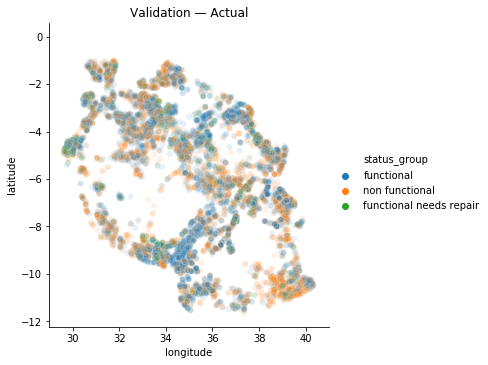

In [0]:
sns.relplot(x='longitude', y='latitude', hue='status_group', data=val, alpha=0.1, 
            hue_order=['functional', 'non functional', 'functional needs repair'])
plt.xlim(29,41)
plt.title('Validation — Actual');

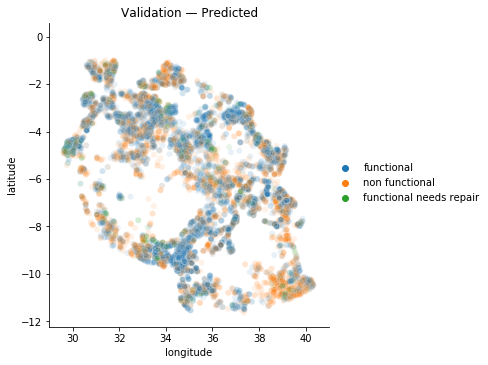

In [0]:
y_pred = model.predict(X_val_encoded)
sns.relplot(x='longitude', y='latitude', hue=y_pred, data=val, alpha=0.1, 
            hue_order=['functional', 'non functional', 'functional needs repair'])
plt.xlim(29,41)
plt.title('Validation — Predicted');

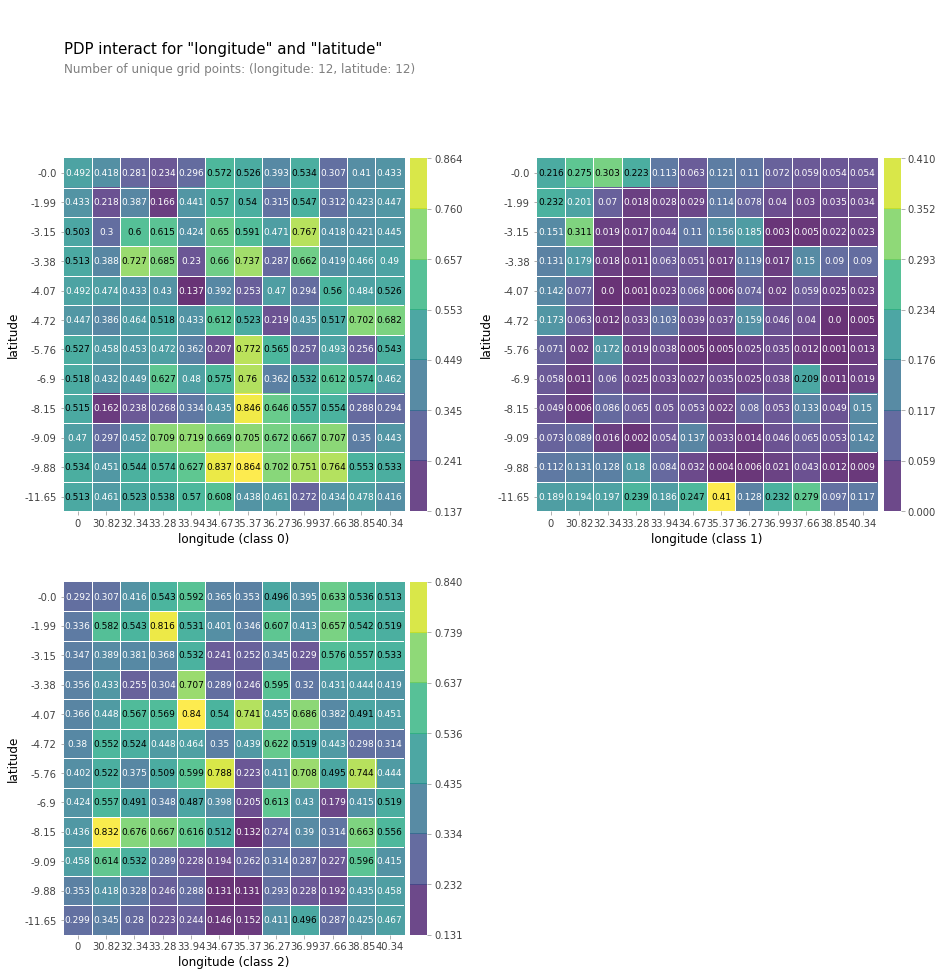

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['longitude', 'latitude']

interaction = pdp_interact(
    model=model, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    features=features, 
    num_grid_points=[12,12]
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Clustering?

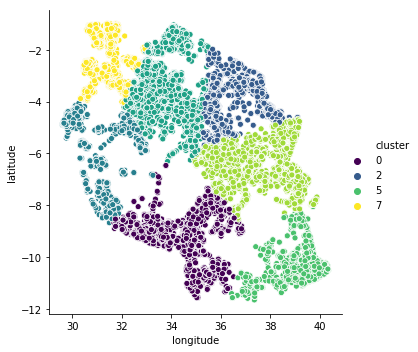

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans()
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
sns.relplot(x='longitude', y='latitude', hue='cluster', palette='viridis', data=train[train.longitude != 0]);

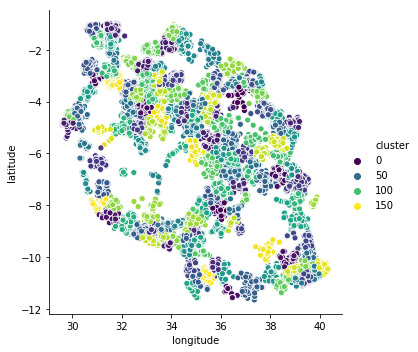

In [0]:
kmeans = KMeans(n_clusters=144)
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
sns.relplot(x='longitude', y='latitude', hue='cluster', palette='viridis', data=train[train.longitude != 0]);

In [0]:
train['cluster'].value_counts().head()

1     1355
67    1124
34     990
60     847
21     783
Name: cluster, dtype: int64

In [0]:
train['cluster'].value_counts().tail()

88     71
6      64
90     62
136    46
63     28
Name: cluster, dtype: int64

### Clustered Location with ordinal encoding doesn't help

In [0]:
val['cluster'] = kmeans.predict(val[['longitude', 'latitude']])

In [0]:
features = ['cluster', 'quantity']
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(train[features])
X_val_encoded = encoder.transform(val[features])
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train_encoded, y_train)
model.score(X_val_encoded, y_val)

0.6919191919191919

### Clustered Location with target/mean encoding doesn't help



In [0]:
train['Needs Repair'] = train['status_group'] != 'functional'
cluster_average = train.groupby('cluster')['Needs Repair'].mean().sort_values()
cluster_average.head()

cluster
43     0.081917
117    0.083969
107    0.118557
83     0.140741
69     0.173152
Name: Needs Repair, dtype: float64

In [0]:
cluster_average.tail()

cluster
56     0.797688
59     0.803468
7      0.807432
133    0.843220
76     0.900000
Name: Needs Repair, dtype: float64

In [0]:
train['cluster_average'] = train['cluster'].map(cluster_average.to_dict())

In [0]:

val['cluster_average'] = val['cluster'].map(cluster_average)

In [0]:
features = ['cluster_average', 'quantity']
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(train[features])
X_val_encoded = encoder.transform(val[features])
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train_encoded, y_train)
model.score(X_val_encoded, y_val)

0.6922558922558922

### Back to the earlier model...

In [0]:
features = ['longitude', 'latitude', 'quantity']
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train[features])
X_val_encoded = encoder.transform(X_val[features])
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train_encoded, y_train)
model.score(X_val_encoded, y_val)

0.7402020202020202

In [0]:
y_pred = model.predict(X_val_encoded)
pd.Series(y_pred).value_counts()

functional                 8708
non functional             5446
functional needs repair     696
dtype: int64

In [0]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_val_encoded)

print(classification_report(y_val, y_pred))


columns = [f'Predicted {label}' for label in np.unique(y_val)]
index = [f'Actual {label}' for label in np.unique(y_val)]
pd.DataFrame(confusion_matrix(y_val, y_pred), columns=columns, index=index)

                         precision    recall  f1-score   support

             functional       0.76      0.82      0.79      8065
functional needs repair       0.43      0.28      0.33      1079
         non functional       0.75      0.71      0.73      5706

               accuracy                           0.74     14850
              macro avg       0.64      0.60      0.62     14850
           weighted avg       0.73      0.74      0.73     14850



,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,6633,261,1171
Actual functional needs repair,569,297,213
Actual non functional,1506,138,4062


In [0]:
train['quantity'].value_counts()

enough          24909
insufficient    11376
dry              4628
seasonal         3039
unknown           598
Name: quantity, dtype: int64

In [0]:
[col for col in train if 'quantity' in col]

['quantity', 'quantity_group']

In [0]:
train['quantity_group'].value_counts()

enough          24909
insufficient    11376
dry              4628
seasonal         3039
unknown           598
Name: quantity_group, dtype: int64

In [0]:
all(train['quantity']==train['quantity_group'])

True